#1. Link Prediction*

``linkpred``라이브러리:link prediction analysis.


In [ ]:
!pip install linkpred

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for linkpred: filename=linkpred-0.5.1-py3-none-any.whl size=28744 sha256=14b734c2d5f582ae98106f10678cd983acce10174965331cde5a6b37db4a0383
  Stored in directory: /root/.cache/pip/wheels/cc/24/15/4f18e6e3718786d97d74dd34e68744b063a338ca1fd677e055
  Created wheel for smokesignal: filename=smokesignal-0.7.0-py3-none-any.whl size=6031 sha256=daa30261a41e374cbb4e42eca5f526127a84c5ec9c1145df27208a329a379537
  Stored in directory: /root/.cache/pip/wheels/4b/b3/8e/a6eb57fab0fecdd37e8ffb5e602cde85ea095ed4d2d2f6c499
Successfully built linkpred smokesignal


In [ ]:
import linkpred

- link prediction 과정
1. Network Loading
2. Predictor selection and application
3. Results evaluation

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [ ]:
data = pd.read_csv("got-s6-edges.csv")
data.head()

,Source,Target,Weight,Season
0,JON,SANSA,151,6
1,MISSANDEI,TYRION,88,6
2,TYRION,VARYS,86,6
3,ARYA,JAQEN,83,6
4,DAVOS,MELISANDRE,82,6


In [ ]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
g = read_net_w('got-s6-edges.csv')

``linkpred`` 라이브러리에서 제공하는 predictor 유형:
- **Neighborhood:**
    - *AdamicAdar*, AssociationStrength, *CommonNeighbours*, Cosine, DegreeProduct, *Jaccard*, MaxOverlap, MinOverlap, NMeasure, Pearson,ResourceAllocation
- **Paths:**
    - GraphDistance, *Katz*
- **Ranking:**
    - *SimRank*, RootedPageRank
- **Miscellanea:**
    - Community, Copy, *Random*
    


- Neighborhood: *How many friend we have to share in order to become friends?*
- Common Neighbors: 공유하는 이웃이 많으면 링크 발생 가능성 높음

In [ ]:
cn = linkpred.predictors.CommonNeighbours(g, excluded=g.edges()) # 기존 엣지 제외한 새로운 링크 예측
cn_results = cn.predict()

top = cn_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 8.0
NED - LADY_CRANE 8.0
NED - CLARENZO 8.0
MARGAERY - IZEMBARO 8.0
MARGAERY - ARYA 8.0


- **Jaccard**

In [ ]:
jc = linkpred.predictors.Jaccard(g, excluded=g.edges())
jc_results = jc.predict()

top = jc_results.top(5)
for edge, score in top.items():
    print(edge, score)

RED_PRIEST - KINVARA 1.0
LITTLE_SAM - DICKON 1.0
TOMMEN - MACE 0.7272727272727273
JOFFREY - CAMELLO 0.7272727272727273
OLD_NAN - BENJEN 0.7142857142857143


- **Adamic Adar**: 서로의 친구를 더 선택할 수록 링크 예측

In [ ]:
aa = linkpred.predictors.AdamicAdar(g, excluded=g.edges())
aa_results = aa.predict()

top = aa_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 3.1875572810307897
NED - LADY_CRANE 3.126371165725784
NED - CLARENZO 3.126371165725783
SANSA - ROBB 3.096644315133247
JOFFREY - CAMELLO 2.8944937119329133


- **Graph Distance**: 두 노드 간 최단 거리 길이

In [ ]:
gd = linkpred.predictors.GraphDistance(g, excluded=g.edges())
gd_results = gd.predict()

top = gd_results.top(5)
for edge, score in top.items():
    print(edge, score)

LADY_CRANE - JAQEN 36.136054421768705
TYRION - DAARIO 30.29268292682927
CERSEI - BRIENNE 28.44827586206896
MELISANDRE - LITTLEFINGER 23.427491305005294
CERSEI - BRONN 23.294117647058822


- Rankig: 두 노드 자체의 유사도
- **SimRank**: 두 노드의 이웃들이 비슷한 두 노드도 비슷

In [ ]:
simrank = linkpred.predictors.SimRank(g, excluded=g.edges())
simrank_results = simrank.predict(c=0.5)

top = simrank_results.top(5)
for edge, score in top.items():
    print(edge, score)

MAESTER_CITADEL - MAESTER_AEMON 0.3920701611834253
RAY - GATINS 0.3886464843365491
GATINS - BERIC 0.3675791855431439
THOROS - GATINS 0.3636591552182033
MAESTER_AEMON - GILLY 0.319889623157789


- 각 predictor 비교

In [ ]:
import random
import itertools
from linkpred.evaluation import Pair

# Building the test network
test = read_net_w(f'got-s7-edges.csv')

# Exclude test network from learning phase
training = g.copy()

# Node set
nodes = list(g.nodes())
nodes.extend(list(test.nodes()))

# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [ ]:
cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

In [ ]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)

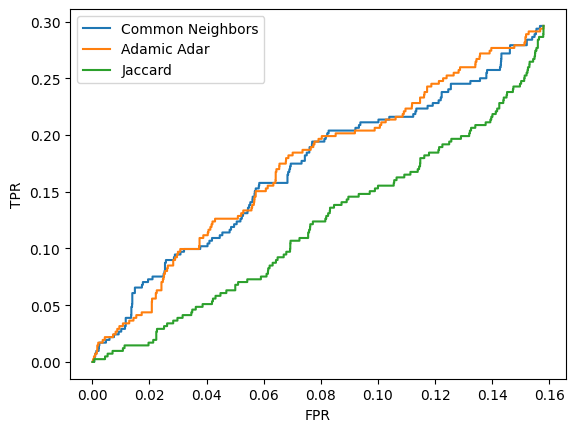

In [ ]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import auc

print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")

Area Under Roc Curve (AUROC)
Common Neigh.: 	 0.026832485313825823
Adamic Adar: 	 0.027259625028069757
Jaccard: 	 0.018894838921578106


#2.Embedding

In [ ]:
!pip install node2vec

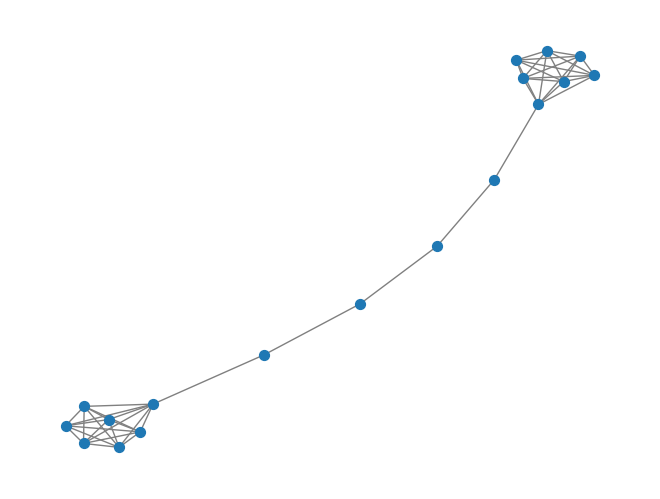

In [ ]:
from node2vec import Node2Vec
import networkx as nx
G = nx.barbell_graph(m1=7, m2=4)
nx.draw(G, nx.spring_layout(G), with_labels=False, node_size=50, edge_color='gray', arrowsize=30)

In [ ]:
# dimension 5
# window 5

In [ ]:
node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/18 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 97.51it/s]


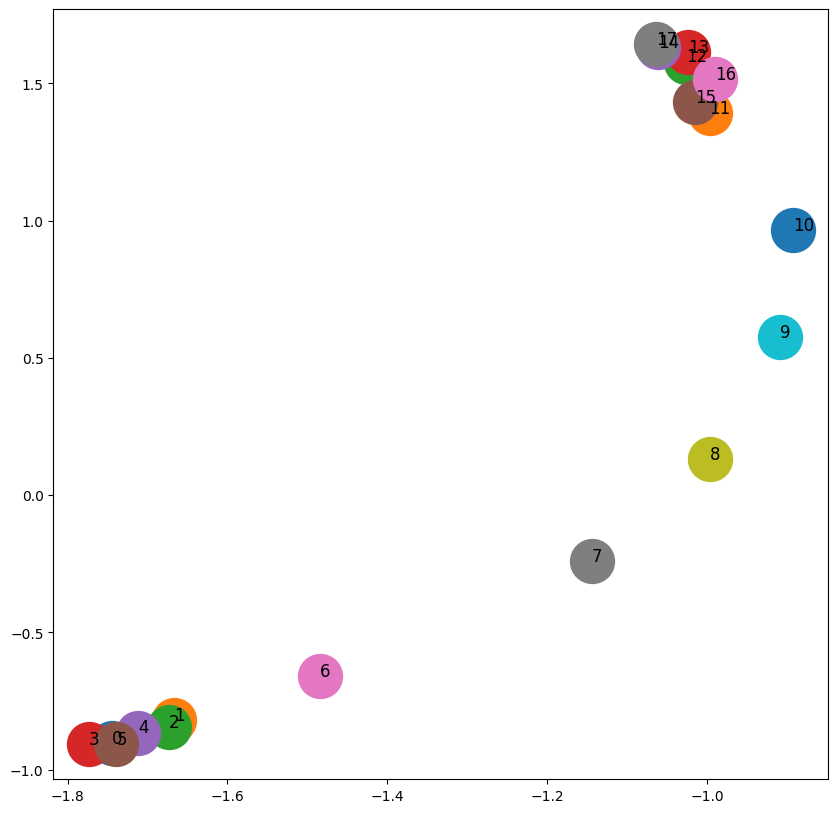

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.nodes():
    v = model.wv.get_vector(str(x))
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=12)

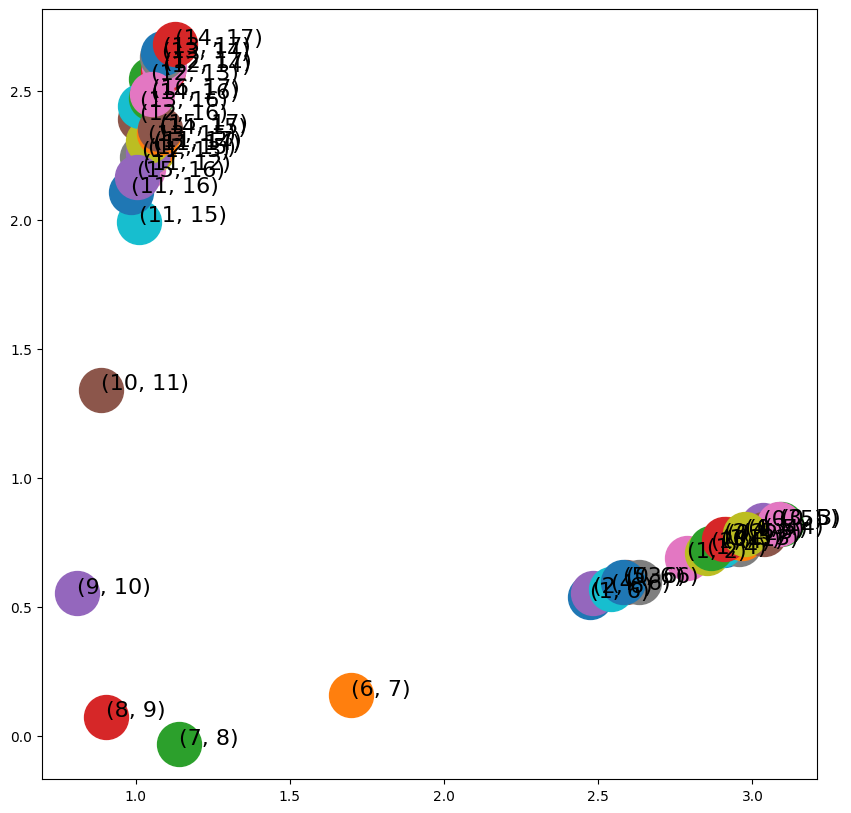

In [ ]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

for x in G.edges():

    v = edges_embs[(str(x[0]), str(x[1]))]
    ax.scatter(v[0],v[1], s=1000)
    ax.annotate(str(x), (v[0],v[1]), fontsize=16)

In [ ]:
!pip install karateclub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 52.1 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=101984 sha256=cef7bad95a3f82a22fa2253d7d212f006afdf687c5afa38e0642dfc8d01910ce
  Stored in directory: /root/.cache/pip/wheels/62/bd/af/17e7ca6ba0ed144d22502780f5c0660a8e4985939dc6973a81
Successfully built karateclub
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8

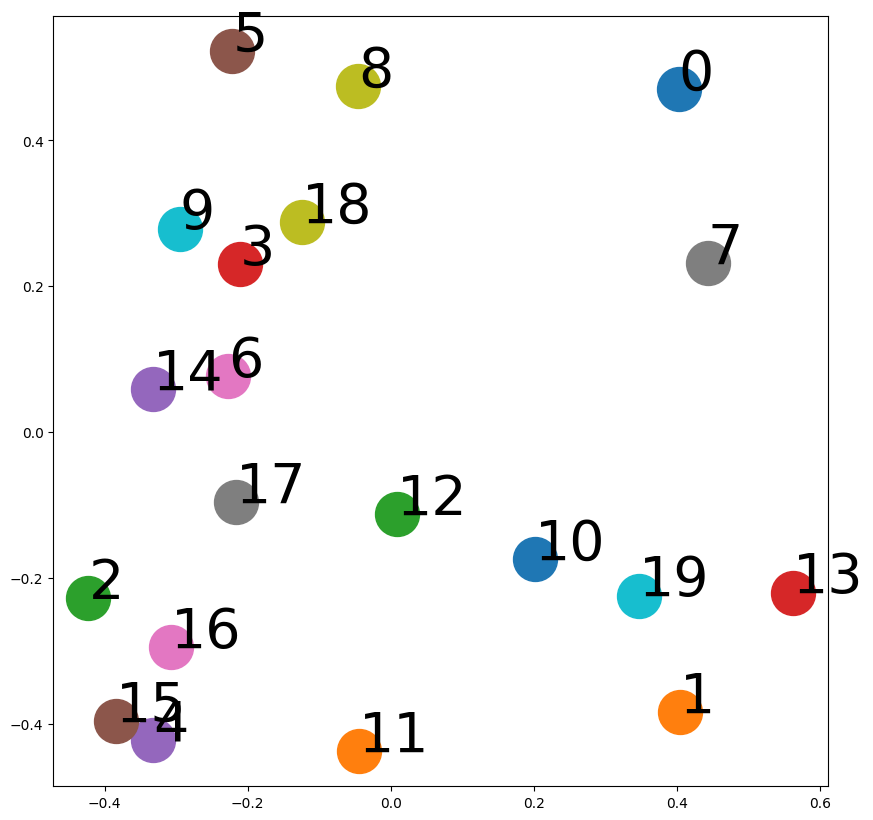

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from karateclub import Graph2Vec

n_graphs = 20

def generate_radom():
    n = random.randint(6, 20)
    k = random.randint(5, n)
    p = random.uniform(0, 1)
    return nx.watts_strogatz_graph(n,k,p), [n,k,p]

Gs = [generate_radom() for x in range(n_graphs)]

model = Graph2Vec(dimensions=2, wl_iterations=10)
model.fit([x[0] for x in Gs])
embeddings = model.get_embedding()

fig, ax = plt.subplots(figsize=(10,10))

for i,vec in enumerate(embeddings):
    ax.scatter(vec[0],vec[1], s=1000)
    ax.annotate(str(i), (vec[0],vec[1]), fontsize=40)
